In [1]:
import os
import json, cv2, numpy as np, matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.models.detection import KeypointRCNN
import albumentations as A
import pandas as pd
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate
import random
import base64
from PIL import Image
from io import BytesIO
from IPython.display import HTML
from torchsummary import summary
import math
from openpyxl import Workbook
from openpyxl.drawing.image import Image as ExcelImage
from openpyxl.utils import get_column_letter
import glob
from natsort import natsorted
import itertools
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from tqdm import tqdm
import datetime
import seaborn as sns
import statistics

print("Using torch", torch.__version__)
print(torch.cuda.is_available())

Using torch 1.13.1+cu117
True


In [2]:
num = 27

train_model = True
load_weights = False
make_labels = False

num_keypoints = 2
save_path = rf'F:\ET_Tube\CheXpert-v1.0\weights\test_weights_{datetime.datetime.now().strftime("%H_%M_%S")}.pth'
save_dir =  r"D:\ET_Tube\CheXpert-v1.0\checkpoints" #checkpoint directory
workbook_path = rf'F:\ET_Tube\CheXpert-v1.0\predictions_{datetime.datetime.now().strftime("%H_%M_%S")}.xlsx'

batch_size = 1
num_epochs = 10

In [3]:
KEYPOINTS_FOLDER_TRAIN = fr"C:\Users\nprim\Downloads\ET_TUBE.v{num}i.yolov7pytorch\train"
KEYPOINTS_FOLDER_VALID = fr"C:\Users\nprim\Downloads\ET_TUBE.v{num}i.yolov7pytorch\valid"
KEYPOINTS_FOLDER_TEST =  fr"C:\Users\nprim\Downloads\ET_TUBE.v{num}i.yolov7pytorch\test"

In [4]:
if make_labels:
    import json
    import zipfile
    path_to_zip_file = fr"C:\Users\nprim\Downloads\ET_TUBE.v{num}i.yolov7pytorch.zip"
    
    BASE = fr"C:\Users\nprim\Downloads\ET_TUBE.v{num}i.yolov7pytorch"
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(BASE)

    SET = ["/train", "/valid", "/test"]
    #SET = ["/train",  "/test"]
    #SET = ["/train", "/valid"]
    #SET = ["/train"]
    #SET = ["/test"]
  
    keypoint_names =  ['Carina', 'ET']

    def dump2json(bboxes, keypoints_sorted, file_json):
        annotations = {}
        annotations['bboxes'], annotations['keypoints'] = bboxes, keypoints_sorted

        with open(file_json, "w") as f:
            json.dump(annotations, f)

    def converter(file_labels, file_image, keypoint_names):

        img = cv2.imread(file_image)
        img_w, img_h = img.shape[1], img.shape[0]
        
        with open(file_labels) as f:
            lines_txt = f.readlines()
            lines = []
            for line in lines_txt:
                lines.append([int(line.split()[0])] + [round(float(el), 5) for el in line.split()[1:]])
        
        bboxes = []
        keypoints = []

        # Convert normalized coordinates to absolute coordinates
        for line in lines:
            # Number 0 is a class of rectangles related to bounding boxes.
            if line[0] == 2:
                x_c, y_c, w, h = round(line[1] * img_w), round(line[2] * img_h), round(line[3] * img_w), round(line[4] * img_h)
                bboxes.append([round(x_c - w/2), round(y_c - h/2), round(x_c + w/2), round(y_c + h/2)])

            elif line[0] == 0 or line[0] == 1: #append all other keypoints without class change
                kp_id, x_c, y_c = line[0], round(line[1] * img_w), round(line[2] * img_h) 
                keypoints.append([kp_id, x_c, y_c])
                

        # iterating over each keypoint and looking to which bounding box it matches, dont need this for patellas
        keypoints_sorted = [[[] for _ in keypoint_names] for _ in bboxes]

        for kp in keypoints:
            kp_id, kp_x, kp_y = kp[0], kp[1], kp[2]
            for bbox_idx, bbox in enumerate(bboxes):
                x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
                if x1 < kp_x < x2 and y1 < kp_y < y2:
                    keypoints_sorted[bbox_idx][kp_id] = [kp_x, kp_y, 1] # All keypoints are visible
                    
        return bboxes, keypoints_sorted


    for i in range(len(SET)):
        IMAGES = BASE + SET[i] + "/images"
        LABELS = BASE + SET[i] + "/labels"
        ANNOTATIONS = BASE +  SET[i] + "/annotations"
        
        files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

        for file in tqdm((files_names), desc =f"Set: {SET[i]}"):
        #for file in (files_names):
            file_labels = os.path.join(LABELS, file + ".txt")
            file_image = os.path.join(IMAGES, file + ".jpg")

            #img = cv2.imread(file_image)
            #if img.shape[0] != img.shape[1]:
                #print("Non square image:", file_image)
                
            bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names)

            for i in keypoints_sorted:
                a,b = i
                if (len(a) != 3 or len (b) != 3) :
                    print("Error in file", file)

            if not os.path.exists(ANNOTATIONS):
                os.makedirs(ANNOTATIONS)

            dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))

In [5]:
IMG_SIZE = 256

def train_transform():
    return A.Compose([
        A.GaussNoise(var_limit=(10, 50), mean=0, per_channel=True, p=0.5), # Simulate sensor noise
        A.ISONoise(intensity=(0.1, 0.5), p=0.5), # Additional noise type
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # Adjust brightness & contrast
        A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5), # Small rotations
        A.HorizontalFlip(p=0.5), # Horizontal flip (use with caution, depending on orientation-specific structures)
        A.CLAHE(clip_limit=(1,4), p=1), # Enhance local contrast
        A.Resize(IMG_SIZE, IMG_SIZE, p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'),
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

def test_valid_transform():
    return A.Compose([
        A.Sequential([
            A.CLAHE(clip_limit=(1,4), p=1),
            A.Resize(IMG_SIZE, IMG_SIZE, p=1)
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), 
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

In [6]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))

        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
                          
            # All objects are patellas, so we can use the same label for all objects
            bboxes_labels_original = ['ROI' for _ in bboxes_original]  


            if self.transform:   
                # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
                # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
                # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
                # Then we need to convert it to the following list:
                # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
                
                keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]

                # Apply augmentations
                transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
                img = transformed['image']
                bboxes = transformed['bboxes']
                
                # Unflattening list transformed['keypoints']
                # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
                # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
                # Then we need to convert it to the following list:
                # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
                
                #keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,3,2)).tolist()

                keypoints_transformed_unflattened = [transformed['keypoints']]


                #keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,3,2)).tolist()
                
                # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
                keypoints = []
                for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                    obj_keypoints = []

                    for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                        # kp - coordinates of keypoint
                        # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                        obj_keypoints.append(np.array(kp).tolist() + [keypoints_original[o_idx][k_idx][2]])
                    keypoints.append(obj_keypoints)
        
            else:
                img, bboxes, keypoints = img_original, bboxes_original, keypoints_original
                 
            # Convert everything into a torch tensor        
            bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
            target = {}
            target["boxes"] = bboxes
            target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64)
            target["image_id"] = torch.tensor([idx])
            target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
            target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)

            target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32) 
            
            img = F.to_tensor(img)
            
            bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
            target_original = {}
            target_original["boxes"] = bboxes_original
            target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are carinas
            target_original["image_id"] = torch.tensor([idx])
            target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
            target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
            target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
            img_original = F.to_tensor(img_original)

            if self.demo:
                return img, target, img_original, target_original
            else:
                return img, target
    
    def __len__(self):
        return len(self.imgs_files)

In [7]:
dataset = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
iterator = iter(data_loader)
batch = next(iterator)

keypoints_classes_ids2names = {0: 'Carina' , 1: 'ET'}

In [8]:
def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None, augmented=True, save=False, save_path=None, display=True):
    fontsize = 12

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 1, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (255,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 1, (255,255,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 1, cv2.LINE_AA)
        

        f, ax = plt.subplots(1, 2, figsize=(40, 20))
        ax[0].set_title('Original image', fontsize=fontsize)
        if augmented:
            ax[1].set_title('Augmented image', fontsize=fontsize)
        else:
            ax[1].set_title('Predicted image', fontsize=fontsize) # also augmented image
    
        ax[0].imshow(image_original)
        ax[1].imshow(image)
        
        if(save):
            print("Saving image to: ", save_path)
            plt.gcf().set_size_inches(5, 10)
            plt.savefig(save_path, dpi=100)
            plt.close()
            
        if(display == False):
            plt.close()

In [9]:
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

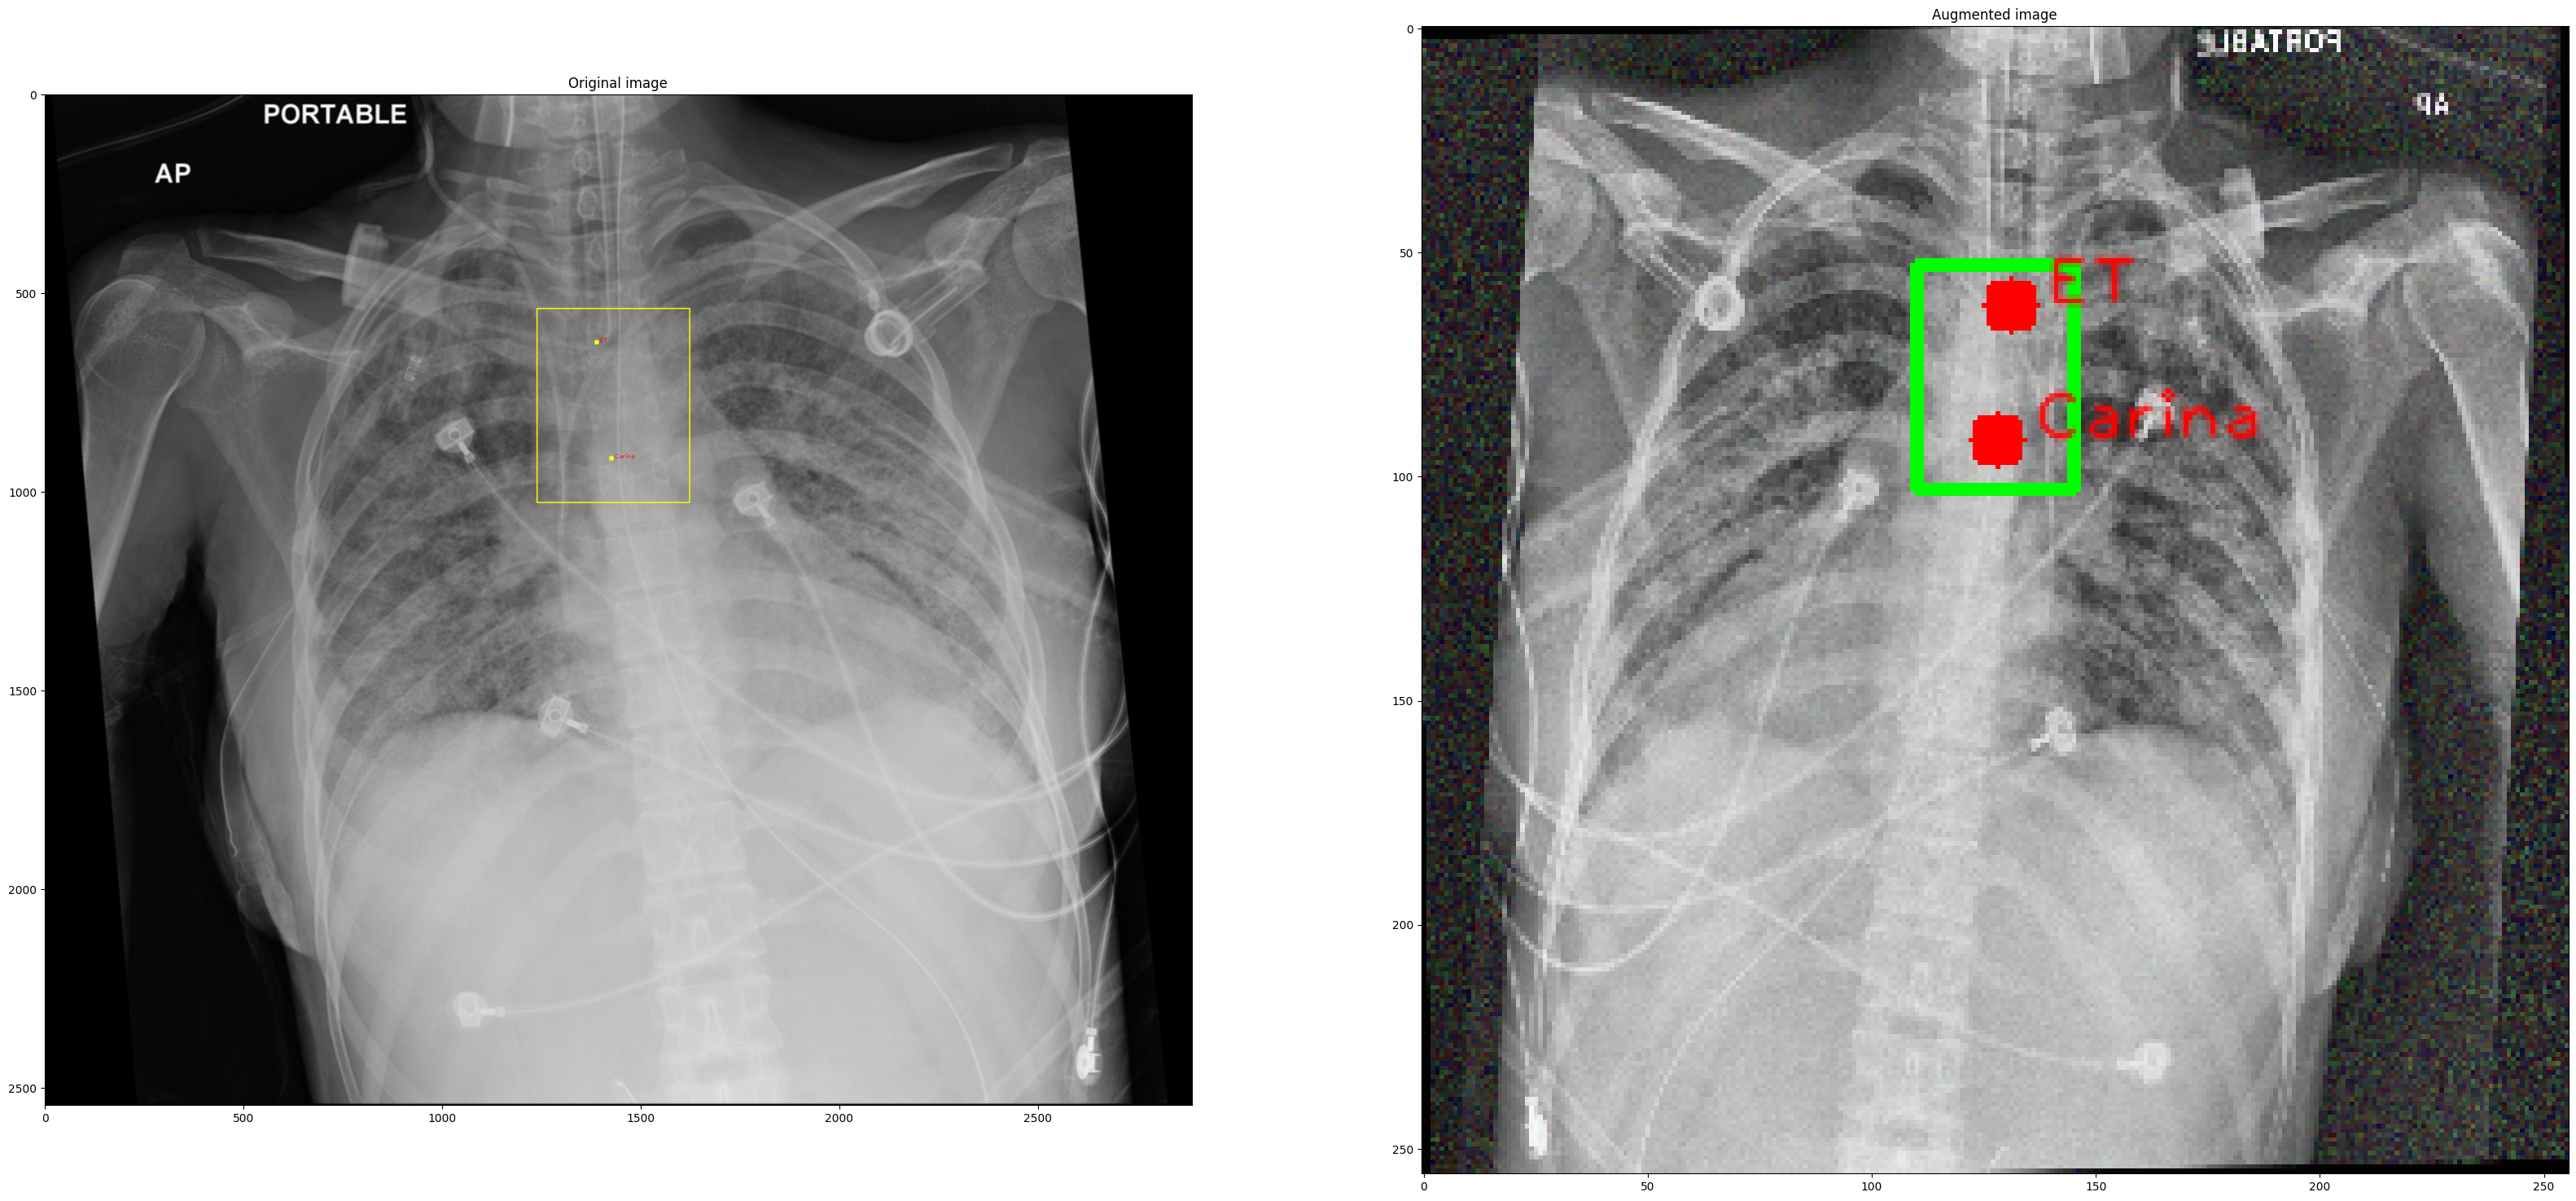

In [10]:
visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original, augmented=True, save=False, save_path=None, display=True)

In [11]:
def get_model(num_keypoints=2, anchor_sizes = (64, 128, 256) , anchor_ratios= (0.5, 0.83, 1.2, 2), weights_path=None):
    
    backbone = torchvision.models.convnext_large(weights='DEFAULT').features
    backbone.out_channels = 1536

    anchor_generator = AnchorGenerator(sizes=(anchor_sizes,), aspect_ratios=(anchor_ratios,))
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)
    keypoint_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                             output_size=14,
                                                             sampling_ratio=2)

    model = KeypointRCNN(backbone,
                          num_classes=2,
                          rpn_anchor_generator=anchor_generator,
                          box_roi_pool=roi_pooler,
                          keypoint_roi_pool=keypoint_roi_pooler,
                          num_keypoints=num_keypoints)        
        
    return model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_valid = ClassDataset(KEYPOINTS_FOLDER_VALID, transform=test_valid_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=test_valid_transform(), demo=False)


data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
data_loader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [13]:
def calc_distance(kp1, kp2):
    x1, y1 = kp1
    x2, y2 = kp2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [14]:
def calc_epoch_error(model, data_loader_test, device):
    with torch.inference_mode():
        model.eval()
        running_epoch_dist_error = 0
        num_keypoint_predictions = 0
        avg_dist_error = 0
        for batch_idx, (images, targets) in enumerate(data_loader_test):
            
            if not targets:
                #print("No targets available for the current batch.")
                continue

            images = list(image.to(device) for image in images)
            predictions = model(images)
            for i in range(len(predictions)):
                for idx in range(num_keypoints):
                    try:
                        pred = predictions[i]['keypoints'][0][idx].detach().cpu().numpy().astype(np.int32)
                        x1, y1, _ = predictions[i]['keypoints'][0][idx].detach().cpu().numpy().astype(np.int32)
                        kp1 = (x1, y1)
                        x2, y2, _ = targets[i]['keypoints'][0][idx].detach().cpu().numpy().astype(np.int32)
                        kp2 = (x2, y2)
                        num_keypoint_predictions += 1
                        running_epoch_dist_error += calc_distance(kp1, kp2)
                        avg_dist_error = running_epoch_dist_error / num_keypoint_predictions
                    except:
                        print("No prediction for val image.")
        print("Running Epoch Error: ", avg_dist_error)
        score = -avg_dist_error
        return score


In [15]:
def save_checkpoint(model, optimizer, epoch, fold, save_dir):
    checkpoint = {
        'epoch': epoch,
        'epoch': fold,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, os.path.join(save_dir, f'checkpoint__{fold}_{epoch}.pt'))

In [16]:
def reset_weights(model):
    for name, module in model.named_modules():
        if not name.startswith("backbone"):
            if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear) or isinstance(model, nn.ConvTranspose2d):
                model.reset_parameters()

In [17]:
def calc_distance(kp1, kp2):
    x1, y1 = kp1
    x2, y2 = kp2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calc_mean_distance_error(real_keypoints, pred_keypoints):
    mean_distance = 0
    point_error = [0,0,0]
    assert len(real_keypoints) == len(pred_keypoints)
    for i in range(len(real_keypoints)):
        for j in range(len(real_keypoints[i])):
            point_error[j] = calc_distance(real_keypoints[i][j], pred_keypoints[i][j])
            mean_distance += point_error[j]
    return mean_distance/len(keypoints), point_error

In [18]:
def get_best_keypoints(scores):
    avg_scores = []
    for score in scores:
        avg_scores.append(torch.mean(score))

    try:
        if len(avg_scores) > 0:
            return avg_scores.index(max(avg_scores))
        else:
            raise ValueError("avg_scores is empty. Make sure you have calculated the average scores before finding the maximum.")
    except ValueError as e:
        print(e)
        return []  # or some other default value
   
    #return avg_scores.index(max(avg_scores))

In [19]:
# Calculate the Proportion of Correct Keypoints (PCK)
# Threshold is the maximum distance between the predicted and ground truth keypoints
# Here it is written (default param) as 10 pixels
# Perhaps this should be a function of the image size?
def calculate_example_pck(total_point_error_list, threshold=10):
    num_correct = 0
    flat_list = list(itertools.chain(*total_point_error_list))

    for point in flat_list:
        if point <= threshold:
            num_correct += 1
            
# Calculate the PCK
    pck = num_correct / len(flat_list)
    return pck

In [20]:
def validate_one_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    criterion = torch.nn.MSELoss() # Loss function
    example_distance_error_list = []
    pred_count = 0

    with torch.no_grad():
        for batch_count, batch  in enumerate(data_loader):
            images, kp = batch
            assert len(images) == len(kp)
            for i in range(len(images)):
                image = images[i].to(device)

                # Get ground truth keypoints, remove visibility column
                kps = torch.squeeze(kp[i]['keypoints'][:, :, :2])

                keypoints_gt = kps.to(device)
                
                # Get predictions
                output = model(image.unsqueeze(0))
                
                # Check if predictions are available
                if len(output) > 0 and 'keypoints' in output[0] and len(output[0]['keypoints']) > 0:
                    #get highest score keypoint preds, again without visibility column
                    keypoints_pred = output[0]['keypoints'][0][:, :-1]

                    # Compute loss
                    loss = criterion(keypoints_pred, keypoints_gt)
                    total_loss += loss.item()
                    pred_count += 1

                    diff = keypoints_pred - keypoints_gt
                    squared_diff = diff ** 2
                    example_distance_error = torch.sqrt(torch.sum(squared_diff))
                    example_distance_error_list.append(example_distance_error)
                else:
                    print(f"No keypoints detected for image: {i}, batch: {batch_count}")

    # Compute average loss and accuracy
    if pred_count > 0:
        avg_loss = total_loss / pred_count
        avg_distance_error = torch.mean(torch.stack(example_distance_error_list))

        print(f"Average Validation Loss: {avg_loss}, Average Validation Distance Error: {avg_distance_error}")
        return avg_loss, avg_distance_error
    else:
        print("No keypoints detected in the entire batch.")
        return None, None


In [21]:
from torch.utils.data import ConcatDataset

def get_full_dataset():
    # Define individual datasets
    dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
    dataset_valid = ClassDataset(KEYPOINTS_FOLDER_VALID, transform=test_valid_transform(), demo=False)

    # Combine the datasets
    full_dataset = ConcatDataset([dataset_train, dataset_valid])

    return full_dataset

In [22]:
from sklearn.model_selection import KFold

# Number of folds
K = 5

# Get the full dataset
full_dataset = get_full_dataset()

# Split the dataset into K folds
kfold = KFold(n_splits=K, shuffle=True, random_state=42)

# Iterate through each fold
for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
    print(f"Fold {fold + 1}/{K}")

    # Create data loaders for this fold
    train_subset = torch.utils.data.Subset(full_dataset, train_ids)
    val_subset = torch.utils.data.Subset(full_dataset, val_ids)

    data_loader_train = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize the model for this fold
    model = get_model()
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.8, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

    for epoch in range(num_epochs):
        model.to(device)
        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
        lr_scheduler.step()

        validate_one_epoch(model, val_loader, device)

        # Save checkpoint for this fold and epoch
        save_checkpoint(model, optimizer, epoch, fold + 1, save_dir)

Fold 1/5
Epoch: [0]  [  0/413]  eta: 0:16:04  lr: 0.000002  loss: 9.5876 (9.5876)  loss_classifier: 0.7133 (0.7133)  loss_box_reg: 0.0269 (0.0269)  loss_keypoint: 8.1614 (8.1614)  loss_objectness: 0.6814 (0.6814)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 2.3342  data: 0.0618  max mem: 4904
Epoch: [0]  [100/413]  eta: 0:04:01  lr: 0.000123  loss: 8.0440 (8.7545)  loss_classifier: 0.0974 (0.3845)  loss_box_reg: 0.0040 (0.0170)  loss_keypoint: 7.3919 (7.7533)  loss_objectness: 0.4739 (0.5944)  loss_rpn_box_reg: 0.0032 (0.0053)  time: 0.7146  data: 0.4867  max mem: 8549
Epoch: [0]  [200/413]  eta: 0:02:45  lr: 0.000244  loss: 7.4054 (8.0601)  loss_classifier: 0.0296 (0.2154)  loss_box_reg: 0.0029 (0.0145)  loss_keypoint: 7.2606 (7.3944)  loss_objectness: 0.1407 (0.4304)  loss_rpn_box_reg: 0.0033 (0.0054)  time: 0.8053  data: 0.5959  max mem: 8549
Epoch: [0]  [300/413]  eta: 0:01:25  lr: 0.000365  loss: 7.1067 (7.7571)  loss_classifier: 0.0436 (0.1571)  loss_box_reg: 0.0163 (0.0144)  loss_k

KeyboardInterrupt: 

In [ ]:
precision_list = []
recall_list = []
NPV_list = []
accuracy_list = []
specificity_list = []
f1_score_list = []
ETT_distance_error_list = []
total_point_error_list = []
pck_list = []


precision_list = []
recall_list = []
NPV_list = []
accuracy_list = []
specificity_list = []
f1_score_list = []
ETT_distance_error_list = []
total_point_error_list = []
pck_small_list = []
pck_large_list = []

example_error_list = []
pred_image_file_list = []
total_mean_distance_error = 0
total_mean_ETT_distance_error = 0
total_number_of_predictions = 0
no_preds_count = 0
total_attempts = 0
batch_count = 0
correct_predictions = 0
incorrect_predictions = 0
correct_real = 0
incorrect_real = 0
TP = 0
FP = 0
TN = 0
FN = 0


#Evaluate the model on the test set
model.to(device)            
model.eval()

batch_count = 0
iterator = iter(data_loader_test)
for item in iterator:
    try:
        images, targets = item
        images = list(image.to(device) for image in images)
    except StopIteration as e:
        print("StopIteration exception handled at batch: ", batch_count)
        

    output = model(images)   
    #print("output: ", output)

    batch_count += 1 

    for prediction_number in range(len(images)):
        
        real_keypoints = [] #list of keypoints for each image in batch

        #unpacking the targets, this is a pain but works to remove the 0/1 visibility dim (which we do not need because all keypoints are visible)
        for kps in targets[prediction_number]['keypoints']:
            real_keypoints.append([list(map(int, kp[:2])) for kp in kps])
        distance_real = calc_distance(real_keypoints[0][0], real_keypoints[0][1])
        #print("Real keypoints: ", real_keypoints)
    
        
        real_bboxes = targets[prediction_number]['boxes'].int().tolist()
        
        #permute(1,2,0) converts the tensor to numpy array. The tensor is in the format (C, H, W) and numpy array is in the format (H, W, C).
        #detach().cpu().numpy() detaches the tensor from the graph and converts it to numpy array and moves it to CPU.
        image = (images[prediction_number].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)  
        
        scores = output[prediction_number]['scores'].detach().cpu().numpy()
        #print("Scores: ", scores)
        if len(scores) == 0:
            print("No keypoints found at image: ", prediction_number)
            no_preds_count += 1
            break


        high_scores_idxs = np.where(scores > 0)[0].tolist() # Indexes of boxes with scores > 0.1
        #print("High Score idxs: ", high_scores_idxs)
        #print("Raw NMS Boxes len: ", len(output[0]['boxes'][high_scores_idxs]))
        #print("Raw NMS scores len: ", len(output[0]['scores'][high_scores_idxs]))
        #print("Raw NMS Boxes len: ", len(output[0]['boxes'][high_scores_idxs]))
        #print("High Score idxs: ", high_scores_idxs)
        #print("Output: ", output)
        
        
        
        #print("Raw NMS scores len: ", len(output[0]['scores'][high_scores_idxs]))
        
        #print("******************")
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        #print("-----------Post NMS idxs:-----------", post_nms_idxs)

        #Making images based on keypoints_scores, instead of bbox scores now
        #print("Raw Keypoint scores: ", output[prediction_number]['keypoints_scores'])
        keypoint_scores = output[prediction_number]['keypoints_scores'][post_nms_idxs]
        #print("Keypoint scores: ", keypoint_scores)
        #print("Keypoint scores: ", keypoint_scores)
        score_idx = get_best_keypoints(keypoint_scores)
        #print("Best Keypoints IDX: ", score_idx)
        #score_idx = 0
        pred_keypoints = []
        keypoints = output[prediction_number]['keypoints'][score_idx].detach().cpu().numpy()
    
        for kp in keypoints:
            kp = list(map(int, kp)) #convert (x,y) coords in each keypoint to int
            pred_keypoints.append(kp[:2])


        if len(pred_keypoints) != 0:
            pred_keypoints = [pred_keypoints] #convert to list of lists to match real_keypoints format
            #print("Pred keypoints: ", pred_keypoints)
        
            distance_pred = calc_distance(pred_keypoints[0][0], pred_keypoints[0][1])
            distance_error = abs(distance_pred - distance_real)
        
        #print("Real ETT to Carina:", distance_real/50)
        #print("Prediencted ETT to Carina:", distance_pred/50)
        #print("ETT to Carina Distance error:" , distance_error/50)

            if ((distance_real/50) <= 3) or ((distance_real/50) >= 7):
                incorrect_real += 1
            else:
                correct_real += 1

            if ((distance_pred/50) <= 3) or ((distance_pred/50) >= 7):
                incorrect_predictions += 1
            else:
                correct_predictions += 1

            if (((distance_real/50) <= 3) or ((distance_real/50) >= 7)) and (((distance_pred/50) <= 3) or ((distance_pred/50) >= 7)):
                TN +=1
                #print("TN")
            elif (((distance_real/50) <= 3) or ((distance_real/50) >= 7)) and (((distance_pred/50) > 3) or ((distance_pred/50) < 7)):
                FN +=1
                #print("FN")
            elif (((distance_real/50) > 3) or ((distance_real/50) < 7)) and (((distance_pred/50) <= 3) or ((distance_pred/50) >= 7)):
                FP +=1
                #print("FP")
            elif (((distance_real/50) > 3) or ((distance_real/50) < 7)) and (((distance_pred/50) > 3) or ((distance_pred/50) < 7)):
                TP +=1
                #print("TP")

            bboxes = []
                
            for bbox in  output[prediction_number]['boxes'][[score_idx]][[0]].detach().cpu().numpy():
                bboxes.append(list(map(int, bbox.tolist())))
            
            
            if (len(bboxes) == 0):
                print("No bounding boxes found at image: ", prediction_number)
                no_preds_count += 1 #count preds with no bounding box at given threshold  
            else:
                total_number_of_predictions += 1    
                example_error, point_error = calc_mean_distance_error(real_keypoints, pred_keypoints)
                total_mean_distance_error += example_error
            
        
            example_point_error = [pt for pt in point_error]
            total_point_error_list.append(example_point_error)
            example_error_list.append(example_error)
            ETT_distance_error_list.append(distance_error)
            

            save_img_path = f"F:\ET_Tube\saved_img_preds\prediction_{str(prediction_number)}_{str(batch_count)}.jpg"
            pred_image_file_list.append(save_img_path)
            visualize(image, bboxes, pred_keypoints, image_original=image, keypoints_original=real_keypoints, bboxes_original=real_bboxes, save=False, save_path = save_img_path, display=False)
            plt.savefig(save_img_path)

        total_attempts += 1

print("Placement Correct predictions: ", correct_predictions)
print("Placement Incorrect predictions: ", incorrect_predictions)
print("Placement Correct real: ", correct_real)
print("Placement Incorrect real: ", incorrect_real)

if total_number_of_predictions != 0:
    total_mean_distance_error /= total_number_of_predictions
print("Total mean Euclidean distance error: ", total_mean_distance_error)
if len(ETT_distance_error_list) != 0:
    total_mean_ETT_distance_error = sum(ETT_distance_error_list)/len(ETT_distance_error_list)
print("Total ETT distance error: ", total_mean_ETT_distance_error)
print("No predictions count: ", no_preds_count)
print("Total attempts: ", total_attempts)

pck_threshold_large = 75
pck_threshold_small = 50
pck_small = calculate_example_pck(total_point_error_list, threshold=pck_threshold_small)
pck_large = calculate_example_pck(total_point_error_list, threshold=pck_threshold_large)
print(f"Fraction of Correct Keypoints: {pck_large:0.3f}, at a threshold of {pck_threshold_large} pixels.")
pck_large_list.append(pck_large)
print(f"Fraction of Correct Keypoints: {pck_small:0.3f}, at a threshold of {pck_threshold_small} pixels.")
pck_small_list.append(pck_small)

print("TP: ", TP)
print("FP: ", FP)
print("TN: ", TN)
print("FN: ", FN)

epsilon = 1e-8 #to avoid division by 0 errors 

precision = TP / (TP + FP + epsilon)
precision_list.append(precision)
print("Precision/PPV: ", precision)
recall = TP / (TP + FN + epsilon)
recall_list.append(recall)
print ("Recall/Sensitivity: ", recall)
NPV = TN / (TN + FN + epsilon)
NPV_list.append(NPV)
print("NPV: ", NPV)
accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
accuracy_list.append(accuracy)
print("Accuracy: ", accuracy)
specificity = TN / (TN + FP + epsilon)
specificity_list.append(specificity)
print("Specificity: ", specificity)
f1_score = 2 * (precision * recall) / (precision + recall + epsilon)
f1_score_list.append(f1_score)
print("F1 Score: ", f1_score)

print("Completed at: ", datetime.datetime.now().strftime("%H:%M:%S"))

In [ ]:
# Old numbers I hand wrote in
eucl_err = [29.192664806593392,30.417407798028098,54.13088229772116, 30.169575240273996]
ETT_err = [16.936977627484584, 17.40249039641634, 17.95239513280611, 18.22531862299226]
precision_list = [0.963414634028852,  0.9390243901293873, 0.926829268179655, 0.9878048779283165]
recall_list = [0.963414634028852, 0.9624999998796876,  0.9743589742340566, 0.9204545453499484]
NPV_list = [0.8888888885596707, 0.8888888885596707, 0.9259259255829904, 0.7407407404663923]
accuracy_list = [0.944954128353674, 0.9266055045021463, 0.9266055045021463, 0.9266055045021463]
specificity_list = [ 0.8888888885596707, 0.8275862066111771, 0.8064516126430801, 0.9523809519274377]
f1_score_list = [ 0.963414629028852,0.9506172788340193, 0.949999994884375, 0.952941171364706 ]
pck_list = [0.991,0.991,0.987, 0.989]

stat_list = [precision_list, recall_list, NPV_list, accuracy_list, specificity_list, f1_score_list, pck_list, eucl_err , ETT_err]

for list_ in stat_list:
    std_dev = statistics.stdev(list_)
    avg = sum(list_)/len(list_)
    print(f"The standard deviation of list is: {std_dev:.3f}")
    print(f"The average of list is: {avg:.3f}")



combined_dataset = ConcatDataset([dataset_train, dataset_test])

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(combined_dataset):

    val_data = [combined_dataset[i] for i in tqdm(val_idx)]

    global data_loader_val
    data_loader_val = DataLoader(val_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [ ]:
confusion_matrix = [
    [TP, FP],
    [FN, TN]
]

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Increase font size
ax = sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="d", annot_kws={"size": 16})
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))

# Set labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for ETT Placement')

# Set tick labels
ax.xaxis.set_ticklabels(['Correct ETT Placement', 'Incorrect ETT Placement'])
ax.yaxis.set_ticklabels(['Correct ETT Placement', 'Incorrect ETT Placement'])

# Show the plot
plt.show()

In [ ]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((500, 250), Image.Resampling.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

df = pd.DataFrame(example_error_list, columns=['Example Error'])
df['pck_small'] = pck_small_list * len(df)
df['pck_large'] = pck_large_list * len(df)
df['file'] = pred_image_file_list
df['image'] = df.file.map(lambda f: get_thumbnail(f))
df.head()

HTML(df[['Example Error', 'image']].to_html(formatters={'image': image_formatter}, escape=False))


In [ ]:
workbook = Workbook()
worksheet = workbook.active

# resize cells
for row in range(2, len(df['file'])+2):
    for col in range(1,2):
        worksheet.row_dimensions[row].height = 400
        col_letter = get_column_letter(col)
        worksheet.column_dimensions[col_letter].width = 150
        
for col in range(2,50):
    col_letter = get_column_letter(col)
    worksheet.column_dimensions[col_letter].width = 30
         
# insert images
for index, image in enumerate(df['file']):
    if index == 0:
        worksheet.cell(row=index+1, column=1, value="Image")
        worksheet.add_image(ExcelImage(image), anchor='A'+str(index+2))
    else:
        worksheet.add_image(ExcelImage(image), anchor='A'+str(index+2))

excel_cell_values = []
for excel_cell_value in df['Example Error']:
    excel_cell_values.append(excel_cell_value)

for index, excel_cell_value in enumerate(excel_cell_values):
    if index == 0:
        worksheet.cell(row=index+1, column=2, value="Example Error")
        worksheet.cell(row=index+2, column=2, value=excel_cell_value)
    else:
        worksheet.cell(row=index+2, column=2, value=excel_cell_value)

# Find the last column
last_column = worksheet.max_column

# Add values to the last column
worksheet.cell(row=1, column=last_column+1).value = f'Total Mean Euclidean Distance Error: {total_mean_distance_error}'
worksheet.cell(row=2, column=last_column+1).value = f'No predictions count: {no_preds_count}'
worksheet.cell(row=6, column=last_column+1).value = f'Fraction of Correct Keypoints at threshold of {pck_threshold_small} pixels: {pck_small}'
worksheet.cell(row=7, column=last_column+1).value = f'Fraction of Correct Keypoints at threshold of {pck_threshold_large} pixels: {pck_large}'

# save workbook
workbook.save(workbook_path)

In [ ]:
def process_and_predict(image_file):
    raw_img = cv2.imread(image_file)
    aspect_ratio = raw_img.shape[0]/raw_img.shape[1]

    if aspect_ratio < 1.5 and aspect_ratio > 0.5:
        raw_img = cv2.resize(raw_img, (456, 456))
        test_img = np.moveaxis(raw_img, -1, 0)
        test_img= np.expand_dims(test_img, axis=0)
        test_img = torch.from_numpy(test_img).float().to(device)

        with torch.no_grad():
            model.to(device)            
            model.eval()
            output = model(test_img)
        
        scores = output[0]['keypoints_scores']
        score_idx = get_best_keypoints(scores)

        keypoints = output[0]['keypoints'][score_idx].detach().cpu().numpy()
        for idx, kp in enumerate(keypoints):
            current_keypoint = kp[:2].astype(int)
            raw_img = cv2.circle(raw_img, current_keypoint, 1, (255,255,0), 10)
            image_original = cv2.putText(raw_img, " " + keypoints_classes_ids2names[idx], current_keypoint, cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2, cv2.LINE_AA)

        plt.figure(figsize=(10,10))
        plt.imshow(raw_img)
    else:
        print(f"Image aspect ratio is {aspect_ratio:0.2F} it but be between 0.5 - 1.5")

        
#test_img = "/mnt/c/Users/nprim/Downloads/F1.jpg"
#process_and_predict(test_img) # random picture from the internet